In [ ]:
"""Teste função compara imagens treino e teste """

def comparar_imagens_e_caracteristicas(treino: pd.DataFrame, avaliacao: pd.DataFrame):
    avaliacao_info_list = []

    for _, row_avaliacao in avaliacao.dropna().iterrows():
        nome_avaliacao = row_avaliacao['nome']
        imagem_avaliacao = row_avaliacao['imagem']

        img, _ = process_image(imagem_avaliacao)

        if img is not None:
            texto_exemplo = nome_avaliacao
            texto_exemplo_sequence = tokenizer.texts_to_sequences([texto_exemplo])
            texto_exemplo_sequence = pad_sequences(texto_exemplo_sequence, maxlen=max_sequence_length, padding='post', truncating='post')
            previsao_probabilidades = model.predict([np.array([img]), texto_exemplo_sequence])

            probabilidade = previsao_probabilidades[0][0]

            avaliacao_categoria = nome_avaliacao
            categoria_prevista = find_matching_category(avaliacao_categoria, treino)

            info_dict = create_info_dict(
                nome_avaliacao, imagem_avaliacao, categoria_prevista, probabilidade
            )

            cores_identificadas = identify_colors(img)

            avaliacao_info_list.append(info_dict)

    return avaliacao_info_list





In [ ]:
resultado_comparacao = comparar_imagens_e_caracteristicas(treino, avaliacao)
for info_dict in resultado_comparacao:
    print(info_dict)


1/1 [==============================] - 1s 1s/step
Informações do Produto Avaliação:
Nome Produto Avaliação: Sofá 3 Lugares Floret Veludo Rosê
Imagem: https://static.mobly.com.br/r/2000x2000/p/Keva-SofC3A1-3-Lugares-Floret-Veludo-RosC3AA-6035-513439-1.jpg
Categoria: Sofá Sala
Probabilidade: 0.6465437412261963
Nome da Cor: white
Código Hexa: #ffffff


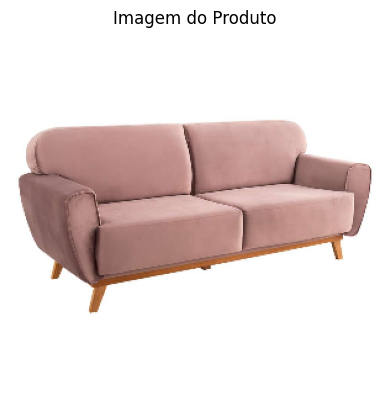

Nome do Produto Avaliação: Sofá 3 Lugares Floret Veludo Rosê
Probabilidade: 0.6465437412261963
Erro ao processar imagem de 'Conjunto Sala de Jantar Cíntia Madesa Mesa Tampo de Madeira com 4 Cadeiras - Rustic/Crema/Pérola'
1/1 [==============================] - 0s 131ms/step
Informações do Produto Avaliação:
Nome Produto Avaliação: Conjunto de Mesa de Jantar Luna com Vidro e 6 Cadeiras Grécia Veludo Chocolate e Off White
Imagem: https://static.mobly.com.br/r/2000x2000/p/Modern-Conjunto-de-Mesa-de-Jantar-Luna-com-Vidro-e-6-Cadeiras-GrC3A9cia-Veludo-Chocolate-e-Off-White-7554-191606-1.jpg?_gl=1*1fkuzu4*_ga*NDI2ODExNjguMTY5NTQyODE3OQ..*_ga_52S02DHY6L*MTY5NjMzNTI5Ni4xMy4xLjE2OTYzMzU3NjIuNTAuMC4w
Categoria: Mesa Escritorio
Probabilidade: 0.5417148470878601
Nome da Cor: white
Código Hexa: #ffffff
Nome da Cor: whitesmoke
Código Hexa: #f5f5f5
Nome da Cor: lightgray
Código Hexa: #d3d3d3
Nome da Cor: silver
Código Hexa: #c0c0c0


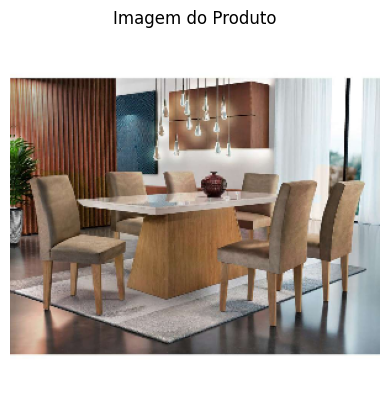

Nome do Produto Avaliação: Conjunto de Mesa de Jantar Luna com Vidro e 6 Cadeiras Grécia Veludo Chocolate e Off White
Probabilidade: 0.5417148470878601
1/1 [==============================] - 0s 129ms/step
Informações do Produto Avaliação:
Nome Produto Avaliação: Guarda-Roupa Casal Premium 6 PT 6 GV Neve
Imagem: https://static.mobly.com.br/r/2000x2000/p/Mobly-Guarda-Roupa-Casal-Premium-6-PT-6-GV-Neve-0129-735433-1.jpg?_gl=1*1etyb8j*_ga*NDI2ODExNjguMTY5NTQyODE3OQ..*_ga_52S02DHY6L*MTY5NjMzNTI5Ni4xMy4xLjE2OTYzMzU4NDguMzAuMC4w
Categoria: Guarda Roupas
Probabilidade: 0.641534149646759
Nome da Cor: lightgray
Código Hexa: #d3d3d3
Nome da Cor: gainsboro
Código Hexa: #dcdcdc


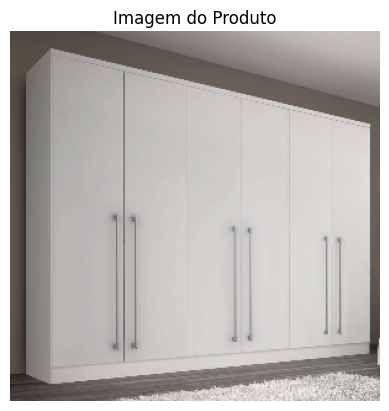

Nome do Produto Avaliação: Guarda-Roupa Casal Premium 6 PT 6 GV Neve
Probabilidade: 0.641534149646759
1/1 [==============================] - 0s 131ms/step
Informações do Produto Avaliação:
Nome Produto Avaliação: Cadeira de Escritório Presidente Giratória com Relax Finland Preta
Imagem: https://static.mobly.com.br/r/2000x2000/p/Mobly-Cadeira-de-EscritC3B3rio-Presidente-GiratC3B3ria-com-Relax-Finland-Preta-6866-201205-1.jpg
Categoria: Cadeira Escritorio
Probabilidade: 0.6775349378585815
Nome da Cor: white
Código Hexa: #ffffff
Nome da Cor: darkgray
Código Hexa: #a9a9a9
Nome da Cor: whitesmoke
Código Hexa: #f5f5f5
Nome da Cor: lightgray
Código Hexa: #d3d3d3
Nome da Cor: silver
Código Hexa: #c0c0c0
Nome da Cor: gainsboro
Código Hexa: #dcdcdc


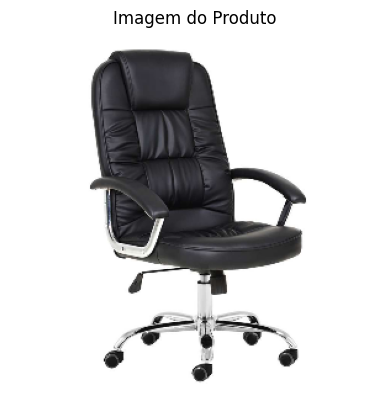

Nome do Produto Avaliação: Cadeira de Escritório Presidente Giratória com Relax Finland Preta
Probabilidade: 0.6775349378585815
1/1 [==============================] - 0s 134ms/step
Informações do Produto Avaliação:
Nome Produto Avaliação: Cadeira de Escritório Secretária Giratória Marilyn Branca
Imagem: https://static.mobly.com.br/r/2000x2000/p/Mobly-Cadeira-de-EscritC3B3rio-SecretC3A1ria-GiratC3B3ria-Marilyn-Branca-4175-492691-1.jpg
Categoria: Cadeira Escritorio
Probabilidade: 0.6122364401817322
Nome da Cor: white
Código Hexa: #ffffff


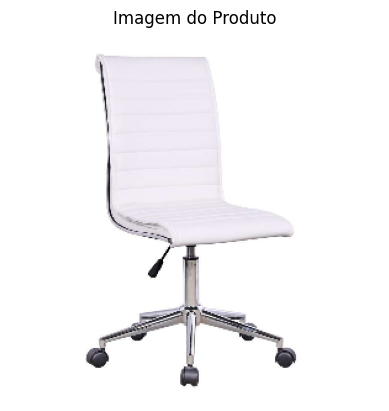

Nome do Produto Avaliação: Cadeira de Escritório Secretária Giratória Marilyn Branca
Probabilidade: 0.6122364401817322
1/1 [==============================] - 0s 125ms/step
Informações do Produto Avaliação:
Nome Produto Avaliação: Conjunto de Mesa de Jantar Berlim II com Tampo de Vidro Off White e 4 Cadeiras Grécia Veludo Creme
Imagem: https://static.mobly.com.br/r/2000x2000/p/Modern-Conjunto-de-Mesa-de-Jantar-Berlim-II-com-Tampo-de-Vidro-Off-White-e-4-Cadeiras-GrC3A9cia-Veludo-Creme-4637-175695-1.jpg
Categoria: Mesa
Probabilidade: 0.6478854417800903
Nome da Cor: white
Código Hexa: #ffffff
Nome da Cor: whitesmoke
Código Hexa: #f5f5f5
Nome da Cor: lightgray
Código Hexa: #d3d3d3
Nome da Cor: gainsboro
Código Hexa: #dcdcdc
Nome da Cor: darkgray
Código Hexa: #a9a9a9
Nome da Cor: silver
Código Hexa: #c0c0c0


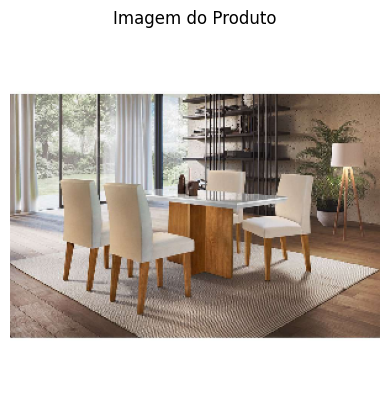

Nome do Produto Avaliação: Conjunto de Mesa de Jantar Berlim II com Tampo de Vidro Off White e 4 Cadeiras Grécia Veludo Creme
Probabilidade: 0.6478854417800903
1/1 [==============================] - 0s 127ms/step
Informações do Produto Avaliação:
Nome Produto Avaliação: Conjunto Sala de Jantar Madesa Talita Mesa Tampo de Madeira com 4 Cadeiras - Rustic/Crema/Pérola
Imagem: https://static.mobly.com.br/r/2000x2000/p/Madesa-Conjunto-Sala-de-Jantar-Madesa-Talita-Mesa-Tampo-de-Madeira-com-4-Cadeiras---Rustic2FCrema2FPC3A9rola-5629-137567-1.jpg
Categoria: Mesa
Probabilidade: 0.5588178038597107


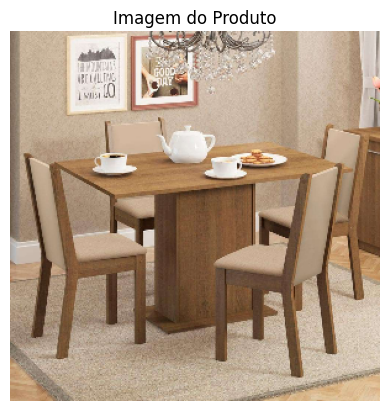

Nome do Produto Avaliação: Conjunto Sala de Jantar Madesa Talita Mesa Tampo de Madeira com 4 Cadeiras - Rustic/Crema/Pérola
Probabilidade: 0.5588178038597107
1/1 [==============================] - 0s 154ms/step
Informações do Produto Avaliação:
Nome Produto Avaliação: Sofá 2 Lugares Vitrola Suede Tabaco
Imagem: https://static.mobly.com.br/r/2000x2000/p/Modern-SofC3A1-2-Lugares-Vitrola-Suede-Tabaco-4944-2127101-1.jpg
Categoria: Sofá Sala
Probabilidade: 0.5147746205329895
Nome da Cor: linen
Código Hexa: #faf0e6


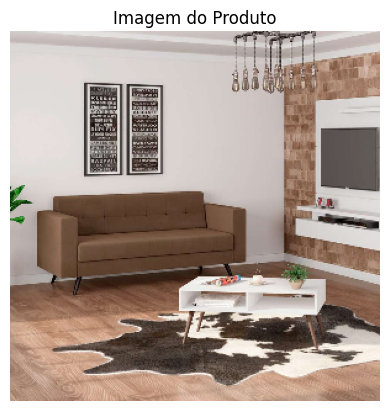

Nome do Produto Avaliação: Sofá 2 Lugares Vitrola Suede Tabaco
Probabilidade: 0.5147746205329895
1/1 [==============================] - 0s 129ms/step
Informações do Produto Avaliação:
Nome Produto Avaliação: Sofá na Caixa Ubbe 3 Lugares com Molas Ensacadas Bouclê Cinza 200 cm
Imagem: https://static.mobly.com.br/r/2000x2000/p/Keva-SofC3A1-na-Caixa-Ubbe-3-Lugares-com-Molas-Ensacadas-BouclC3AA-Cinza-200-cm-7926-8208411-1.jpg
Categoria: Sofá Sala
Probabilidade: 0.5787140727043152
Nome da Cor: darkgray
Código Hexa: #a9a9a9
Nome da Cor: silver
Código Hexa: #c0c0c0


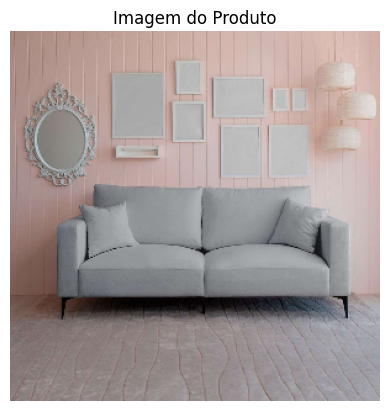

Nome do Produto Avaliação: Sofá na Caixa Ubbe 3 Lugares com Molas Ensacadas Bouclê Cinza 200 cm
Probabilidade: 0.5787140727043152
1/1 [==============================] - 0s 127ms/step
Informações do Produto Avaliação:
Nome Produto Avaliação: Cômoda Colors Madeira Maciça 6 GV Castanho Verniz e Colorido Envelhecido
Imagem: https://static.mobly.com.br/r/2000x2000/p/Keva-CC3B4moda-Colors-Madeira-MaciC3A7a-6-GV-Castanho-Verniz-e-Colorido-Envelhecido-7321-440065-1.jpg
Categoria: Comoda Quarto
Probabilidade: 0.6801830530166626
Nome da Cor: white
Código Hexa: #ffffff


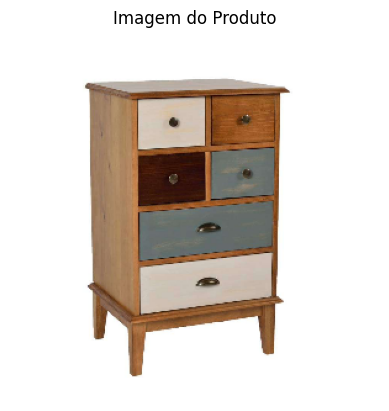

Nome do Produto Avaliação: Cômoda Colors Madeira Maciça 6 GV Castanho Verniz e Colorido Envelhecido
Probabilidade: 0.6801830530166626
1/1 [==============================] - 0s 128ms/step
Informações do Produto Avaliação:
Nome Produto Avaliação: Cômoda Vegas 4 GV Natural Rustico
Imagem: https://static.mobly.com.br/r/2000x2000/p/Keva-CC3B4moda-Vegas-4-GV-Natural-Rustico-2975-660884-1.jpg
Categoria: Comoda Quarto
Probabilidade: 0.6216846704483032
Nome da Cor: white
Código Hexa: #ffffff
Nome da Cor: whitesmoke
Código Hexa: #f5f5f5


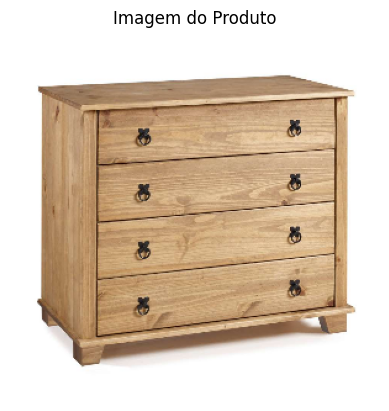

Nome do Produto Avaliação: Cômoda Vegas 4 GV Natural Rustico
Probabilidade: 0.6216846704483032


In [51]:
import cv2
import numpy as np
import os
import pandas as pd
import requests
from io import BytesIO
import tensorflow as tf
from tensorflow.keras.layers import (
    Input,
    Embedding,
    LSTM,
    Attention,
    Dropout,
    Dense,
    GlobalAveragePooling2D,
    GlobalAveragePooling1D,
    concatenate,
)
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import webcolors
import matplotlib.pyplot as plt
from typing import Tuple, Dict, List, Optional, Union

import warnings
warnings.filterwarnings("ignore")


class AttentionLayer(tf.keras.layers.Layer):
    def __init__(self, use_scale=True, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)
        self.use_scale = use_scale

    def build(self, input_shape):
        self.w_q = self.add_weight(
            name='w_q',
            shape=(input_shape[-1], input_shape[-1]),
            initializer='uniform',
            trainable=True
        )
        self.w_k = self.add_weight(
            name='w_k',
            shape=(input_shape[-1], input_shape[-1]),
            initializer='uniform',
            trainable=True
        )
        super(AttentionLayer, self).build(input_shape)

    def call(self, inputs):
        q = tf.matmul(inputs, self.w_q)
        k = tf.matmul(inputs, self.w_k)
        v = inputs
        if self.use_scale:
            q /= tf.sqrt(tf.cast(tf.shape(k)[-1], tf.float32))
        attn_scores = tf.matmul(q, k, transpose_b=True)
        attn_scores = tf.nn.softmax(attn_scores, axis=-1)
        output = tf.matmul(attn_scores, v)
        return output

    def compute_output_shape(self, input_shape):
        return input_shape


def identify_colors(image: np.ndarray) -> List[Dict[str, str]]:
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    small_image = cv2.resize(image_rgb, (100, 100))
    color_list = small_image.reshape(-1, small_image.shape[-1])
    color_info = []
    for color in color_list:
        try:
            closest_color = webcolors.rgb_to_name(color)
            color_hex = "#{:02x}{:02x}{:02x}".format(color[0], color[1], color[2])
            color_info.append({'name': closest_color, 'hex': color_hex})
        except ValueError:
            pass

    unique_colors = []
    for color in color_info:
        if color not in unique_colors:
            unique_colors.append(color)
    return unique_colors


def process_image(image_path: str, resize: bool = True) -> Tuple[Optional[np.ndarray], Optional[str]]:
    if image_path.startswith('http'):
        response = requests.get(image_path)
        if response.status_code == 200:
            img_data = BytesIO(response.content)
            img = cv2.imdecode(np.frombuffer(img_data.read(), np.uint8), 1)
            if img is not None:
                if resize:
                    img = cv2.resize(img, (300, 300))
                return img, image_path
    elif os.path.exists(image_path):
        img = cv2.imread(image_path)
        if img is not None:
            if resize:
                img = cv2.resize(img, (300, 300))
            return img, image_path
    return None, None


def calculate_text_similarity(text1: str, text2: str) -> float:
    set1 = set(text1.lower().split())
    set2 = set(text2.lower().split())
    intersection = set1.intersection(set2)
    union = set1.union(set2)
    return len(intersection) / len(union) if len(union) > 0 else 0.0


def find_matching_category(avaliacao_nome: str, treino: pd.DataFrame) -> str:
    max_similarity = 0.0
    matching_category = ""
    for _, row_treino in treino.iterrows():
        nome_treino = row_treino['nome']
        similarity = calculate_text_similarity(avaliacao_nome, nome_treino)
        if similarity > max_similarity:
            max_similarity = similarity
            matching_category = row_treino['Categoria']
    return matching_category


def create_info_dict(nome: str, imagem: str, categoria: str, probabilidade: float) -> Dict[str, Union[str, str, float]]:
    info_dict = {
        'Nome Produto Avaliação': nome,
        'Imagem': imagem,
        'Categoria': categoria,
        'Probabilidade': probabilidade,
    }
    return info_dict


def comparar_imagens_e_caracteristicas(treino: pd.DataFrame, avaliacao: pd.DataFrame):
    avaliacao_info_list = []

    for _, row_avaliacao in avaliacao.dropna().iterrows():
        nome_avaliacao = row_avaliacao['nome']
        imagem_avaliacao = row_avaliacao['imagem']

        img, _ = process_image(imagem_avaliacao)

        if img is not None:
            texto_exemplo = nome_avaliacao
            texto_exemplo_sequence = tokenizer.texts_to_sequences([texto_exemplo])
            texto_exemplo_sequence = pad_sequences(texto_exemplo_sequence, maxlen=max_sequence_length, padding='post', truncating='post')
            previsao_probabilidades = model.predict([np.array([img]), texto_exemplo_sequence])

            probabilidade = previsao_probabilidades[0][0]

            avaliacao_categoria = nome_avaliacao
            categoria_prevista = find_matching_category(avaliacao_categoria, treino)

            info_dict = create_info_dict(
                nome_avaliacao, imagem_avaliacao, categoria_prevista, probabilidade
            )

            cores_identificadas = identify_colors(img)

            avaliacao_info_list.append(info_dict)

    return avaliacao_info_list

root_dir: str = r'D:\imagesapp\images' 


treino: Optional[pd.DataFrame] = pd.read_csv(os.path.join(root_dir, 'images.csv'), sep=";")
avaliacao: Optional[pd.DataFrame] = pd.read_csv(os.path.join(root_dir, 'avaliacao.csv'), sep=";")

if treino is not None and avaliacao is not None:

  
    tokenizer: Tokenizer = Tokenizer(oov_token="<OOV>")
    tokenizer.fit_on_texts(treino['nome'])

    texts_train_sequences: np.ndarray = tokenizer.texts_to_sequences(treino['nome'])
    max_sequence_length: int = 300
    texts_train_sequences = pad_sequences(texts_train_sequences, maxlen=max_sequence_length, padding='post', truncating='post')
    text_vocab_size: int = len(tokenizer.word_index) + 1

  
    base_model = tf.keras.applications.MobileNetV2(input_shape=(224, 224, 3),
                                                   include_top=False,
                                                   weights='imagenet')
    base_model.trainable = False

    input_image = Input(shape=(300, 300, 3))
    resized_input_image = tf.keras.layers.experimental.preprocessing.Resizing(224, 224)(input_image)

    mobilenet_output = base_model(resized_input_image)

    image_output = GlobalAveragePooling2D()(mobilenet_output)

    input_text: tf.Tensor = Input(shape=(max_sequence_length,), dtype=tf.int32)
    text_model: tf.keras.Model = tf.keras.Sequential([
        Embedding(input_dim=text_vocab_size, output_dim=256, input_length=max_sequence_length),
        LSTM(512, return_sequences=True),
        LSTM(512, return_sequences=True),
        AttentionLayer(use_scale=True),
        GlobalAveragePooling1D(),
    ])
    text_output: tf.Tensor = text_model(input_text)

    combined: tf.Tensor = concatenate([image_output, text_output])
    x: tf.Tensor = Dense(2048, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(combined)
    x = Dropout(0.6)(x)
    output: tf.Tensor = Dense(1, activation='sigmoid')(x)

    model: tf.keras.Model = Model(inputs=[input_image, input_text], outputs=output)

    for layer in base_model.layers:
        layer.trainable = True

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    
    avaliacao_info_list = comparar_imagens_e_caracteristicas(treino, avaliacao)

   
    for info_dict in avaliacao_info_list:
        print("Informações do Produto Avaliação:")
        for key, value in info_dict.items():
            print(f"{key}: {value}")

        print(f"Nome do Produto Avaliação: {info_dict['Nome Produto Avaliação']}")
        print(f"Probabilidade: {info_dict['Probabilidade']}")

        print("Cores Identificadas:")
        img, _ = process_image(info_dict['Imagem'])
        cores_identificadas = identify_colors(img)
        for color_info in cores_identificadas:
            print(f"Nome da Cor: {color_info['name']}")
            print(f"Código Hexa: {color_info['hex']}")

        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.title('Imagem do Produto')
        plt.axis('off')
        plt.show()
